In [26]:
import os
import os.path

import pickle
import pandas as pd

from tqdm import tqdm

import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")

# 1. Загрузим ИНН и названия вузов

In [19]:
with open('..\\data\\raw\\vuz_inn.pickle', 'rb') as f:
        vuz_inn = pickle.load(f)

In [20]:
vuz_inn.head()

,region_name,region_code,full_name,post_address,inn,is_avtonomnaya,is_akkreditovannoye,is_byudzhetnoye,is_voyennoye,is_gosudarstvennoye,...,is_inclusive,is_kazennoye,is_kultury,is_mezhgosudarstvennoye,is_munitsipalnoye,is_negosudarstvennaya,is_nekommercheskaya,is_technologies,is_federalnoye,is_chastnoye
0,Тюменская область,72,федеральное государственное казенное военное о...,"625001, г. Тюмень, улица Льва Толстого, д. 1",7203255254,False,False,False,True,True,...,False,True,False,False,False,False,False,False,True,False
1,Вологодская область,35,федеральное государственное бюджетное образова...,"162600, Вологодская область, г. Череповец, про...",3528051834,False,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
2,г. Москва,77,федеральное государственное бюджетное образова...,"117997, г. Москва, Стремянный переулок, д. 36",7705043493,False,False,True,False,True,...,False,False,False,False,False,False,False,False,True,False
3,"образовательные учреждения, находящиеся за пре...",90,Государственное образовательное учреждение выс...,"Республика Армения, г. Ереван, ул. Овсепа Эмин...",00053474,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Воронежская область,36,Воронежский институт высоких технологий - авто...,"394043, г. Воронеж, ул. Ленина, д. 73а",3662006761,True,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False


# 2. Посчитаем для каких вузов доступна финансовая информация

Источник данных - сведения о планах финансово-хозяйственной деятельности https://bus.gov.ru/open-data.
Определим, для каких вузов финансовая информация доступна на bus.gov.ru. 
Берем финансовую информацию за все года что есть.

нашлось сохраненное years_num
Финансовая информация доступна для 71.625 % ВУЗов


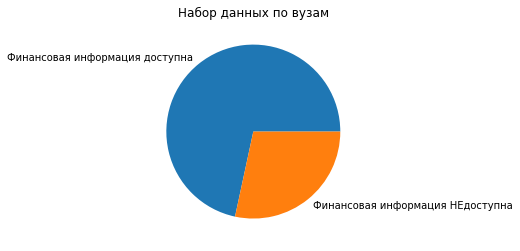

In [21]:
# %%pycodestyle
data_dir = os.path.dirname(os.getcwd()) + '\\data\\raw'
file_list = os.listdir(data_dir)
if 'years_num.pickle' in file_list:
    print('нашлось сохраненное years_num')
    with open('..\\data\\raw\\years_num.pickle', 'rb') as f:
        years_num = pickle.load(f)
else:
    years_num = []
    for i in tqdm(range(800)):
        inn = vuz_inn['inn'][i]
        url = 'https://bus.gov.ru/public-rest/api/epbs/fap.json?inn=' + inn
        response = requests.get(url)
        data = response.json()

        if data['content'] == []:
            years_num.append(0)
        else:
            temp = []
            for i in range(len(data['content'])):
                temp.append(data['content'][i]['common']['financialYear'])
            years_num.append(len(temp))
    with open('..\\data\\raw\\years_num.pickle', 'wb') as f:
        pickle.dump(years_num, f)

vuz_inn['years_num'] = years_num

years_num_unique = vuz_inn['years_num'].unique()

print('Финансовая информация доступна для',
      len(vuz_inn[vuz_inn['years_num'] > 0])*100/800,
      '% ВУЗов')

TOTAL_NUMBER = 800
FIN_INFO_AVAILABLE = len(vuz_inn[vuz_inn['years_num'] > 0])
FIN_INFO_UNAVAILABLE = len(vuz_inn[vuz_inn['years_num'] == 0])

vus_general = {'Финансовая информация доступна': FIN_INFO_AVAILABLE,
               'Финансовая информация НЕдоступна':FIN_INFO_UNAVAILABLE}
vus_general_ser = pd.Series(vus_general) 

# Make the plot with pandas
vus_general_ser.plot(kind='pie', subplots=True)
plt.title("Набор данных по вузам")
plt.ylabel("")
plt.show()

In [24]:
vuz_inn[['full_name', 'years_num']].head()

,full_name,years_num
0,федеральное государственное казенное военное о...,0
1,федеральное государственное бюджетное образова...,4
2,федеральное государственное бюджетное образова...,10
3,Государственное образовательное учреждение выс...,0
4,Воронежский институт высоких технологий - авто...,0


# 3. Отбросим ВУЗы, у которых недоступна финансовая информация

In [27]:
# %%pycodestyle
vuz_inn_fin = vuz_inn[vuz_inn['years_num'] > 0]
vuz_inn_fin.reset_index(inplace=True)
vuz_inn_fin.drop(['index'], axis=1, inplace=True)
print('Осталось', len(vuz_inn_fin), 'вузов')

Осталось 573 вузов


In [28]:
no_data = vuz_inn[vuz_inn['years_num'] == 0]['full_name']
print("Для этих ", len(no_data), " вузов нет данных:\n")
n = 1
for i in vuz_inn[vuz_inn['years_num'] == 0]['full_name']:
    print(n, '-', i)
    n += 1

Для этих  227  вузов нет данных:

1 - федеральное государственное казенное военное образовательное учреждение высшего образования «Тюменское высшее военно-инженерное командное училище имени маршала инженерных войск А.И.Прошлякова» Министерства обороны Российской Федерации
2 - Государственное образовательное учреждение высшего профессионального образования Российско-Армянский (Славянский) университет
3 - Воронежский институт высоких технологий - автономная некоммерческая образовательная организация высшего образования
4 - федеральное государственное казенное военное образовательное учреждение высшего образования «Военная академия радиационной, химической и биологической защиты имени Маршала Советского Союза С.К. Тимошенко (г. Кострома)» Министерства обороны Российской Федерации
5 - Автономная некоммерческая организация высшего образования «Современный технический университет»
6 - Образовательное учреждение профсоюзов высшего образования «Академия труда и социальных отношений»
7 - Частно

55 - федеральное государственное казенное образовательное учреждение высшего образования «Белгородский юридический институт Министерства внутренних дел Российской Федерации имени И.Д. Путилина»
56 - федеральное государственное казенное образовательное учреждение высшего образования «Орловский юридический институт Министерства внутренних дел Российской Федерации имени В.В. Лукьянова»
57 - Негосударственное частное некоммерческое образовательное учреждение высшего образования «Армавирский гуманитарно-социальный институт»
58 - Автономная некоммерческая организация высшего образования «Национальный открытый институт г.Санкт-Петербург»
59 - Негосударственное образовательное учреждение организация высшего образования «Российская академия адвокатуры и нотариата»
60 - федеральное государственное казенное образовательное учреждение высшего образования «Голицынский пограничный институт Федеральной службы безопасности Российской Федерации»
61 - Автономная некоммерческая организация высшего образо

113 - Частное образовательное учреждение высшего образования «Международный Институт Дизайна и Сервиса»
114 - федеральное государственное казенное образовательное учреждение высшего образования «Ростовский юридический институт Министерства внутренних дел Российской Федерации»
115 - Частное образовательное учреждение высшего образования «Кумертауский институт экономики и права»
116 - Частное учреждение высшего образования «Российский исламский институт»
117 - федеральное государственное казенное образовательное учреждение высшего образования «Университет прокуратуры Российской Федерации»
118 - Автономная некоммерческая образовательная организация высшего образования «Воронежский экономико-правовой институт»
119 - Автономная некоммерческая образовательная организация высшего образования «Европейский университет в Санкт-Петербурге»
120 - Негосударственное образовательное частное учреждение высшего образования «Московский экономический институт»
121 - Негосударственное образовательное част

170 - федеральное государственное казенное военное образовательное учреждение высшего образования «Краснодарское высшее военное орденов Жукова и Октябрьской Революции Краснознаменное училище имени генерала армии С.М.Штеменко» Министерства обороны Российской Федерации
171 - Частное образовательное учреждение высшего образования «Русская христианская гуманитарная академия»
172 - Автономная некоммерческая организация высшего образования «Международный банковский институт имени Анатолия Собчака»
173 - Автономная некоммерческая организация высшего образования «Международный банковский институт имени Анатолия Собчака»
174 - федеральное государственное казенное военное образовательное учреждение высшего образования «Череповецкое высшее военное инженерное ордена Жукова училище  радиоэлектроники» Министерства обороны Российской Федерации  
175 - Образовательная автономная некоммерческая организация высшего образования «Волжский университет имени В.Н. Татищева» (институт)
176 - частное образоват

226 - Негосударственное образовательное учреждение высшего профессионального образования «Санкт-Петербургский Гуманитарный университет профсоюзов»
227 - федеральное государственное казенное образовательное учреждение высшего образования «Хабаровский пограничный институт Федеральной службы безопасности Российской Федерации»


# 4. Загрузим по api финансовые показатели ВУЗов